In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/DL/Final_Project/

/content/drive/MyDrive/DL/Final_Project


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device in use:',device)

Device in use: cuda


In [ ]:
import matplotlib.pyplot as plt

In [ ]:

def get_mnist_dataloader(batch_size=64, shuffle=True,model='teacher',omit=None):
    # Define the data transformation
    if model == 'teacher':
      transform_train = transforms.Compose([
          transforms.ToTensor(),  # Convert images to PyTorch tensors
          transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to the range [-1, 1]
          transforms.RandomAffine(0,(0.2,0.2))
      ])
    else:
      transform_train = transforms.Compose([
          transforms.ToTensor(),  # Convert images to PyTorch tensors
          transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to the range [-1, 1]
      ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to the range [-1, 1]

    ])

    # Download MNIST dataset
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

    # Omit specific labels
    if omit is not None:
        indices = [i for i, (image, label) in enumerate(mnist_train) if label != omit]
        mnist_train = torch.utils.data.Subset(mnist_train, indices)

    # Create data loaders
    train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

## get the training, validation and testing datasets


In [ ]:
## general training function
def train_model(model,optimizer,criterion,model_name,train_loader,epochs,t=1):
  train_losses, train_accs = [],[]
  teacher = {}
  teacher['T'] = t
  ## keep track of acc to save the best model
  best_acc = 0

  for epoch in range(epochs):
    print(f"----------------------------------EPOCH {epoch}--------------------------------------")
    train_loss = 0
    total_examples = 0
    correct_examples = 0
    model.train()
    ## model training
    for inputs, targets in train_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      model_outputs = model(inputs)
      output_predictions = torch.argmax(model_outputs, dim=1)
      model_outputs /= t
      model_loss = criterion(model_outputs, targets)
      model_loss.backward()
      optimizer.step()

      train_loss += model_loss.item()
      correct_examples += torch.sum((output_predictions==targets))
      total_examples += targets.size(0)
    ## compute the average training loss/acc for the epoch

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print("\n Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    ## save the best model
    if avg_acc > best_acc:
      best_acc = avg_acc
      torch.save(model.state_dict(), model_name)
      print('Saving model....')

  ## save the results
  teacher['train loss'] = train_losses
  teacher['train accs'] = train_accs
  teacher['best acc'] = best_acc

  ## plot the learning curve for training/validation
  plt.plot(np.arange(1,epochs+1),np.array(train_losses),label='training curve')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Curves')

  return teacher


In [ ]:
def test_model(test_model,teacher):
  correct_examples = 0
  total_examples = 0
  test_model.eval()

  with torch.no_grad():
      for test_data, test_labels in test_loader:
          # Assuming your_model is your trained neural network
          test_data=test_data.to(device)
          test_labels=test_labels.to(device)
          output_predictions = test_model(test_data)

          # Calculate accuracy
          _, predicted = torch.max(output_predictions, 1)
          correct_examples += (predicted == test_labels).sum().item()
          total_examples += test_labels.size(0)

  accuracy = correct_examples / total_examples
  print(f"Accuracy: {accuracy * 100:.2f}%")
  print("\nCorrect:",correct_examples)
  print("\nTotal:",total_examples)
  teacher['correct'] = correct_examples
  teacher['test acc'] = accuracy

In [ ]:
## define the teacher architecture
class parent(nn.Module):
  def __init__(self):
    super(parent, self).__init__()
    self.linear1 = nn.Linear(28*28, 1200)
    self.linear2 = nn.Linear(1200,1200)
    self.linear3 = nn.Linear(1200, 10)
    self.dropout_hidden = nn.Dropout(0.5)
    self.dropout_visible = nn.Dropout(0.2)

  def forward(self,x):
    flatten = x.view(x.size(0),-1)
    x = self.dropout_visible(flatten)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.dropout_hidden(x)
    x = self.linear3(x)
    return x

In [ ]:
## define the student architecture
class student(nn.Module):
  def __init__(self):
    super(student, self).__init__()
    self.linear1 = nn.Linear(28*28, 30)
    self.linear2 = nn.Linear(30,30)
    self.linear3 = nn.Linear(30, 10)

  def forward(self,x):
    flatten = x.view(x.size(0),-1)
    x = F.relu(self.linear1(flatten))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

In [ ]:
## load the teacher model trained on the full MNIST dataset
teacher_model = parent()
teacher_model = teacher_model.to(device)
optimizer_large = optim.SGD(teacher_model.parameters(), lr=0.01, momentum=0.9)
criterion_large = nn.CrossEntropyLoss()
teacher_model.load_state_dict(torch.load('teacher.pth'))

<All keys matched successfully>

## Student model trained with missing number


In [ ]:
number = 9
train_loader, test_loader = get_mnist_dataloader(batch_size=64, shuffle=True,model='student',omit=number)
optimal_alpha = 0.5
optimal_temp = 2.5


----------------------------------EPOCH 0--------------------------------------

 Training loss: 0.4297, Training accuracy: 0.8667
Saving model....
----------------------------------EPOCH 1--------------------------------------

 Training loss: 0.2000, Training accuracy: 0.9398
Saving model....
----------------------------------EPOCH 2--------------------------------------

 Training loss: 0.1558, Training accuracy: 0.9524
Saving model....
----------------------------------EPOCH 3--------------------------------------

 Training loss: 0.1351, Training accuracy: 0.9589
Saving model....
----------------------------------EPOCH 4--------------------------------------

 Training loss: 0.1230, Training accuracy: 0.9627
Saving model....
----------------------------------EPOCH 5--------------------------------------

 Training loss: 0.1144, Training accuracy: 0.9635
Saving model....
----------------------------------EPOCH 6--------------------------------------

 Training loss: 0.1081, Trainin

{'T': 1,
 'train loss': [0.4296594686056735,
  0.19997716423057946,
  0.155778922700494,
  0.13514320274605554,
  0.12304284541410278,
  0.11440049087099687,
  0.10805288167483003,
  0.09990357374662213,
  0.09236387582220269,
  0.08752956696504936,
  0.08391514301366178,
  0.08202080088460917,
  0.07673244062430892,
  0.07563427537211255,
  0.07328073178699031,
  0.06896240296718505,
  0.06791789199903431,
  0.06572896893764432,
  0.06363666193200188,
  0.06263906302577375,
  0.061587796182669255,
  0.05939853123165998,
  0.054369603029931705,
  0.056098825619115146,
  0.05596413586754352,
  0.05560433537218466,
  0.055084272582061895,
  0.05529857131579516,
  0.04957143443928668,
  0.052556219122912626],
 'train accs': [tensor(0.8667, device='cuda:0'),
  tensor(0.9398, device='cuda:0'),
  tensor(0.9524, device='cuda:0'),
  tensor(0.9589, device='cuda:0'),
  tensor(0.9627, device='cuda:0'),
  tensor(0.9635, device='cuda:0'),
  tensor(0.9667, device='cuda:0'),
  tensor(0.9695, device='

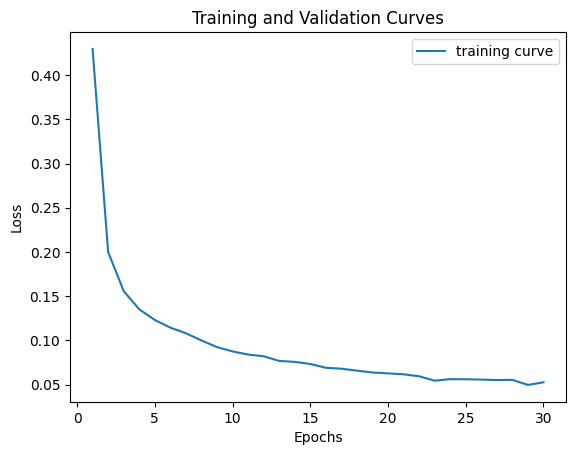

In [ ]:
# Training the smaller Network
smaller_net = student()
smaller_net = smaller_net.to(device)
optimizer_small = optim.SGD(smaller_net.parameters(), lr=0.01, momentum=0.9)
criterion_small = nn.CrossEntropyLoss()

train_model(smaller_net,optimizer_small,criterion_small,'studentw9.pth',train_loader,30)

## testing without distillation

In [ ]:
curr = {}
studentwo = student()
studentwo = studentwo.to(device)
studentwo.load_state_dict(torch.load('studentw0.pth',map_location=torch.device('cuda')))
test_model(studentwo,curr)

Accuracy: 86.83%

Correct: 8683

Total: 10000


In [ ]:
curr = {}
studentwo = student()
studentwo = studentwo.to(device)
studentwo.load_state_dict(torch.load('studentw1.pth',map_location=torch.device('cuda')))
test_model(studentwo,curr)

Accuracy: 85.67%

Correct: 8567

Total: 10000


In [ ]:
curr = {}
studentwo = student()
studentwo = studentwo.to(device)
studentwo.load_state_dict(torch.load('studentw2.pth',map_location=torch.device('cuda')))
test_model(studentwo,curr)

Accuracy: 86.91%

Correct: 8691

Total: 10000


In [ ]:
curr = {}
studentwo = student()
studentwo = studentwo.to(device)
studentwo.load_state_dict(torch.load('studentw3.pth',map_location=torch.device('cuda')))
test_model(studentwo,curr)

Accuracy: 87.06%

Correct: 8706

Total: 10000


In [ ]:
curr = {}
studentwo = student()
studentwo = studentwo.to(device)
studentwo.load_state_dict(torch.load('studentw4.pth',map_location=torch.device('cuda')))
test_model(studentwo,curr)

Accuracy: 87.32%

Correct: 8732

Total: 10000


In [ ]:
curr = {}
studentwo = student()
studentwo = studentwo.to(device)
studentwo.load_state_dict(torch.load('studentw5.pth',map_location=torch.device('cuda')))
test_model(studentwo,curr)

Accuracy: 88.38%

Correct: 8838

Total: 10000


In [ ]:
curr = {}
studentwo = student()
studentwo = studentwo.to(device)
studentwo.load_state_dict(torch.load('studentw6.pth',map_location=torch.device('cuda')))
test_model(studentwo,curr)

Accuracy: 87.70%

Correct: 8770

Total: 10000


In [ ]:
curr = {}
studentwo = student()
studentwo = studentwo.to(device)
studentwo.load_state_dict(torch.load('studentw7.pth',map_location=torch.device('cuda')))
test_model(studentwo,curr)

Accuracy: 86.68%

Correct: 8668

Total: 10000


In [ ]:
curr = {}
studentwo = student()
studentwo = studentwo.to(device)
studentwo.load_state_dict(torch.load('studentw8.pth',map_location=torch.device('cuda')))
test_model(studentwo,curr)

Accuracy: 87.73%

Correct: 8773

Total: 10000


In [ ]:
curr = {}
studentwo = student()
studentwo = studentwo.to(device)
studentwo.load_state_dict(torch.load('studentw9.pth',map_location=torch.device('cuda')))
test_model(studentwo,curr)

Accuracy: 86.99%

Correct: 8699

Total: 10000


Optimal parameters
1. alpha = 0.5, temperature = 2.5


In [ ]:
grid_results = []

In [ ]:
number = 9
train_loader, test_loader = get_mnist_dataloader(batch_size=64, shuffle=True,model='student',omit=number)
a = 0.5
t = 2.5


In [ ]:
## function to perform distillation
current_grid = {}
current_grid['number'] = number
model_name = 'distilled_A'+str(number) + '.pth'
val_accs = []
best_val_acc = 0
## instantiate a new student model for distillation
distilled_net = student()
distilled_net = distilled_net.to(device)
optimizer = optim.SGD(distilled_net.parameters(), lr=0.01, momentum=0.9)

## start the training process
best_acc = 0
train_losses = []
train_accs = []
for epoch in range(0,30):
  train_loss = 0
  correct_examples = 0
  total_examples = 0
  distilled_net.train()
  for inputs, targets in train_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()

      student_targets = distilled_net(inputs)  ## student softmax values
      teacher_targets = teacher_model(inputs) ## teacher softmax values
      loss = a*F.cross_entropy(student_targets/t, F.softmax(teacher_targets/t,dim=1))*(t**2) + F.cross_entropy(student_targets, targets)*(1-a)

      output_predictions = torch.argmax(student_targets, dim=1)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      correct_examples += torch.sum((output_predictions==targets))
      total_examples += targets.numel()

  avg_loss = train_loss / len(train_loader)
  avg_acc = correct_examples / total_examples
  train_losses.append(avg_loss)
  train_accs.append(avg_acc)

  distilled_net.eval()
  with torch.no_grad():
    for test_data, test_labels in test_loader:
        # Assuming your_model is your trained neural network
        test_data=test_data.to(device)
        test_labels=test_labels.to(device)
        output_predictions = distilled_net(test_data)

        # Calculate accuracy
        _, predicted = torch.max(output_predictions, 1)
        correct_examples += (predicted == test_labels).sum().item()
        total_examples += test_labels.size(0)

  #avg_loss = train_loss / len(student_train_loader)
  avg_acc = correct_examples / total_examples
  val_accs.append(avg_acc)
  ## save the best model
  if avg_acc > best_val_acc:
    best_val_acc = avg_acc
    torch.save(distilled_net.state_dict(), model_name)
  #print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

## save the results
current_grid['best accuracy'] = best_acc
current_grid['train loss'] = train_losses
current_grid['train accs'] = train_accs



In [ ]:
grid_results.append(current_grid)

In [ ]:
len(grid_results)

2

In [ ]:
file = open('n710_a25_results.txt','w')
for result in grid_results:
	file.write(str(result)+"\n")
file.close()


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A1.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 93.18%

Correct: 9318

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A2.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 89.81%

Correct: 8981

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A3.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 92.31%

Correct: 9231

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A4.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 91.16%

Correct: 9116

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A5.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 91.44%

Correct: 9144

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A6.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 91.91%

Correct: 9191

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A7.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 91.68%

Correct: 9168

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A8.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 93.50%

Correct: 9350

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A9.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 91.56%

Correct: 9156

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A0.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 89.48%

Correct: 8948

Total: 10000


In [ ]:
## look at the data distribution in the test loader

In [ ]:
cnt = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
for _,targets in test_loader:
  for target in targets:
    cnt[int(target)] += 1


In [ ]:
cnt

{0: 980,
 1: 1135,
 2: 1032,
 3: 1010,
 4: 982,
 5: 892,
 6: 958,
 7: 1028,
 8: 974,
 9: 1009}

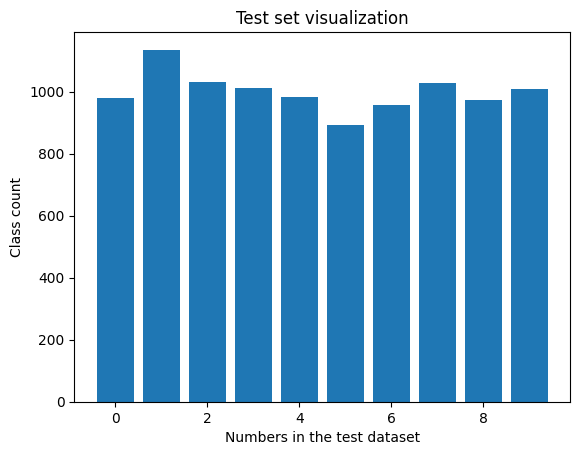

In [ ]:
plt.bar(cnt.keys(),cnt.values())
plt.xlabel('Numbers in the test dataset')
plt.ylabel('Class count')
plt.title('Test set visualization')
plt.show()